# Altair demo

In [4]:
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [5]:
source = data.stocks()
source

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
5,MSFT,2000-06-01,32.54
6,MSFT,2000-07-01,28.40
7,MSFT,2000-08-01,28.40
8,MSFT,2000-09-01,24.53
9,MSFT,2000-10-01,28.02


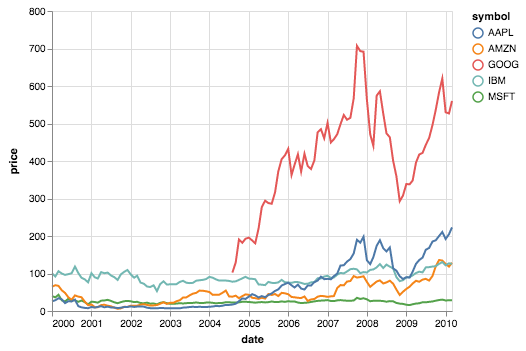

In [6]:
alt.Chart(source).mark_line().encode(
    x='date',
    y='price',
    color='symbol'
)

In [ ]:
source = data.stocks()
source